In [7]:
from utils.geotif_io import readTiff
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr

In [8]:
path_setp_vec = 'data/boundary/setp_zhao2022.gpkg'
path_dem = 'data/dem-data/srtm-c/SRTMGL3_900m.tif'
path_result_dems = 'data/aster-stereo/result_dems.nc'


In [17]:
dem, dem_info = readTiff(path_dem)
result_dems_xr = xr.open_dataset(path_result_dems)
years = result_dems_xr.years
result_dems_xr


<xarray.Dataset>
Dimensions:                      (tiles_id: 28, bins_id: 50, years: 22)
Coordinates:
  * tiles_id                     (tiles_id) object 'tile_31_93' ... 'tile_29_91'
  * bins_id                      (bins_id) object '2500-2600' ... '7400-7500'
  * years                        (years) object '2000' '2001' ... '2020' '2021'
Data variables: (12/13)
    tiles_lat                    (tiles_id) int64 ...
    tiles_lon                    (tiles_id) int64 ...
    area_glacier_bins            (bins_id) float64 ...
    area_glacier_tiles           (tiles_id) float64 ...
    ele_change_setp_cor          (years) float64 ...
    ele_change_setp_cor_error    (years) float64 ...
    ...                           ...
    ele_rate_setp                float64 ...
    ele_rate_setp_error          float64 ...
    ele_rate_tiles               (tiles_id) float64 ...
    ele_rate_tiles_error         (tiles_id) float64 ...
    ele_rate_bins                (bins_id) float64 ...
    ele_rate_bins_error          (bins_id) float64 ...

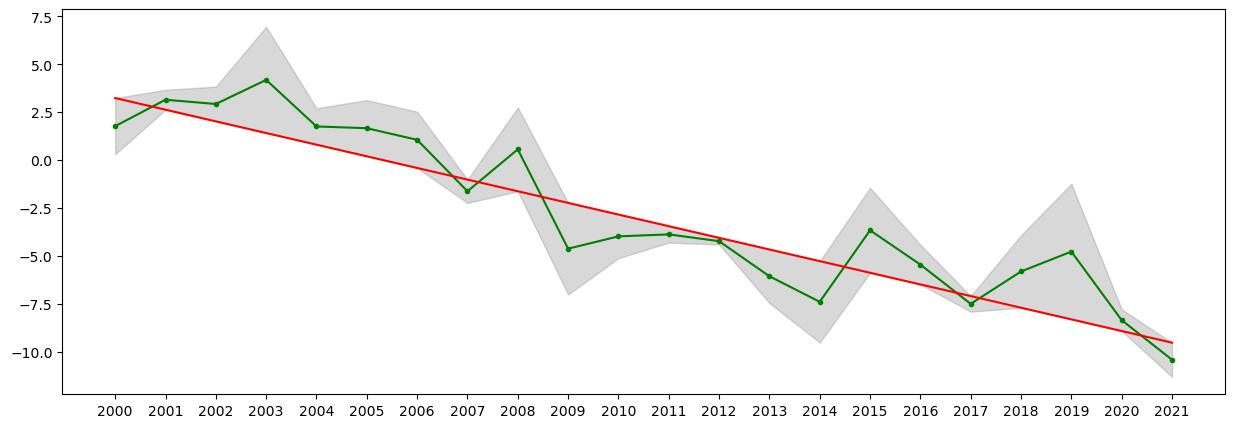

In [14]:
plt.figure(figsize=(15,5))
residual_fit = abs(result_dems_xr['ele_change_setp_cor'] - result_dems_xr['ele_change_setp_cor_fitting'])

plt.plot(years, result_dems_xr['ele_change_setp_cor'], '.-g', label='bins weighting and then tiles weighting')   ### bin-based area weighting -> tile-based area weighting
plt.plot(years, result_dems_xr['ele_change_setp_cor_fitting'], '-r', label='bins weighting and then tiles weighting')   ### bin-based area weighting -> tile-based area weighting
plt.fill_between(years, result_dems_xr['ele_change_setp_cor'] - residual_fit, \
                 result_dems_xr['ele_change_setp_cor'] + residual_fit,
                 color='gray', alpha=0.3)


### Tile-based elevation change mapping

['$\\mathdefault{200}$', '$\\mathdefault{400}$', '$\\mathdefault{600}$']


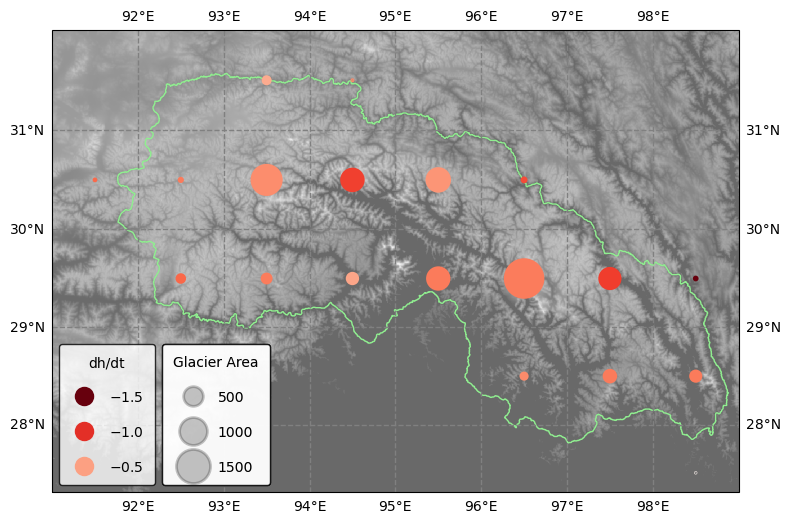

In [18]:
# Scatterplot
cmap_dem = LinearSegmentedColormap.from_list('linear color', ["DimGray", "white"])
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))
ax.set_extent([91, 99, 27.3, 32])
ax_dem = ax.imshow(dem, extent=dem_info['geoextent'], 
                                vmin=3500, vmax=7000, cmap=cmap_dem, \
                                transform=ccrs.PlateCarree(), zorder=0)   ## cmap:PRGn

## 1. Tibeteau southeast boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_vec).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='lightgreen', linewidth=1, facecolor='none')
ax.add_feature(shp_fea, zorder=0)

cmap_dhdt=plt.cm.get_cmap('Reds').reversed()

scatter = ax.scatter(
    x = result_dems_xr['tiles_lon']+0.5, 
    y = result_dems_xr['tiles_lat']+0.5, 
    s = result_dems_xr['area_glacier_tiles']/2.5,
    c = result_dems_xr['ele_rate_tiles'],
    cmap=cmap_dhdt,
    alpha=1, 
    linewidth=2,
    vmax=0,
    vmin=-1.5,
    transform=ccrs.PlateCarree(),
    )

ax.gridlines(draw_labels=True, linewidth=1, alpha=1, zorder=1, color='grey', linestyle='--')

# produce a legend with the unique colors from the scatter
handles, labels = scatter.legend_elements(prop="colors", num=[-1.5, -1, -0.5])
legend1 = ax.legend(handles, labels, loc="lower left", title="dh/dt",\
                            facecolor='white', edgecolor='black', borderpad=0.8, labelspacing=1.5, markerscale=2)

# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", num=[500/2.5, 1000/2.5, 1500/2.5], alpha=0.2)
print(labels)
legend2 = ax.legend(handles, [500, 1000, 1500], loc="lower left", title="Glacier Area", \
                                                edgecolor='black', borderpad = 0.8, labelspacing=1.5, bbox_to_anchor=(0.15, 0.))

ax.add_artist(legend1)
ax.add_artist(legend2)



### Bin-based elevation change mapping


Text(0.5, 1.0, 'selected tile')

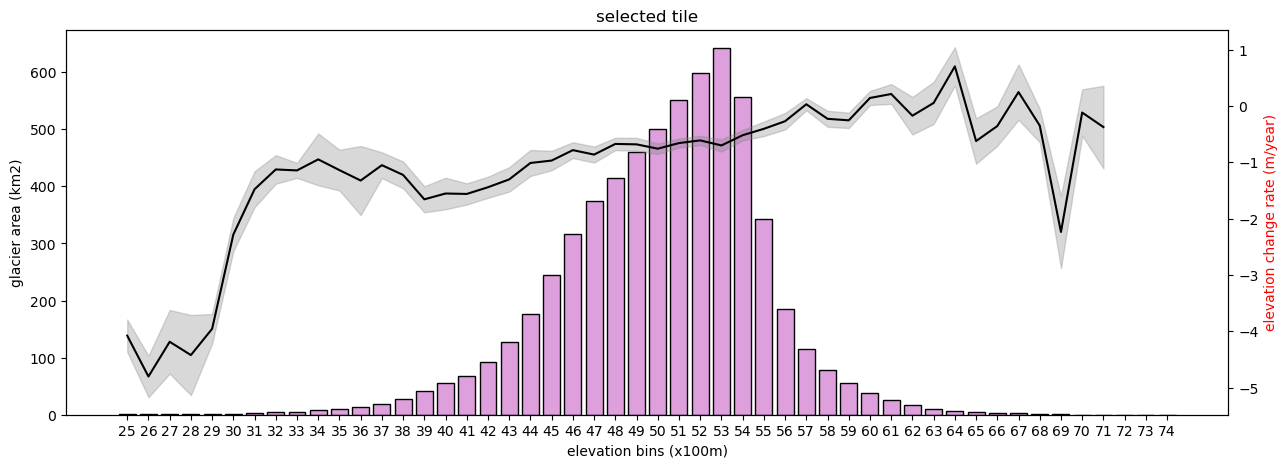

In [20]:
bins_id = result_dems_xr['bins_id'].values
bins_id_start = [bin_id[0:2] for bin_id in bins_id]
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111) # Create matplotlib axes
ax1.bar(bins_id_start, result_dems_xr['area_glacier_bins'], color ='Plum', edgecolor ='black')
ax1.set_ylabel('glacier area (km2)')
ax1.set_xlabel('elevation bins (x100m)')
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.
ax2.set_ylabel('elevation change rate (m/year)', color='red')
ax2.plot(bins_id_start, result_dems_xr['ele_rate_bins'], 'black')
plt.fill_between(bins_id_start, result_dems_xr['ele_rate_bins'] - result_dems_xr['ele_rate_bins_error'], \
                 result_dems_xr['ele_rate_bins'] + result_dems_xr['ele_rate_bins_error'],
                 color='gray', alpha=0.3)

# ax2.hlines(y=0, xmin=0, xmax=50, colors='green')
# plt.xticks([1, 25, 50], [2500, 5000, 7500])
plt.xlabel('elevation (m)')
plt.title('selected tile')

